In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wobble
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['figure.figsize'] = (12.0, 4.0)

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from matplotlib import rcParams

rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 300

orbital_period = 51.4167

In [3]:
def get_spectra(epoch, order, return_header=False):
    spectra = sorted(glob.glob('thuban/data/song-395/*.fits'))
    spectrum = spectra[epoch]
    wav, flux, flux_err = [], [], []
    spectra_data = pf.getdata( spectrum ) # Get the data
    spectra_hdr = pf.getheader( spectrum ) # Get the full header
    if return_header:
        return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:], spectra_hdr
    return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:]

In [23]:
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def interpolate_spectrum(x, y, oversample=5):
    f1  = interpolate.interp1d(x, y, kind = 'cubic')
    df = x[1] - x[0]
    int_wav = np.arange(x[0], x[-1], df / oversample)
    int_flux = f1(int_wav)
    return int_wav, int_flux

def smooth_spectrum(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten_spectrum(x, y, k=3, s=10):
    spl = UnivariateSpline(x, y, k=k, s=s)
    return y / spl(x)

def resolve_spectrum(x, y):
    # Interpolate
    wav, flux = interpolate_spectrum(x,y)
    # Smooth
    flux = smooth_spectrum(wav, flux)
    # Flatten
    flux = flatten_spectrum(wav, flux)
    
    return wav, flux

In [24]:
%run thuban/setup.py

([], <a list of 0 Text yticklabel objects>)

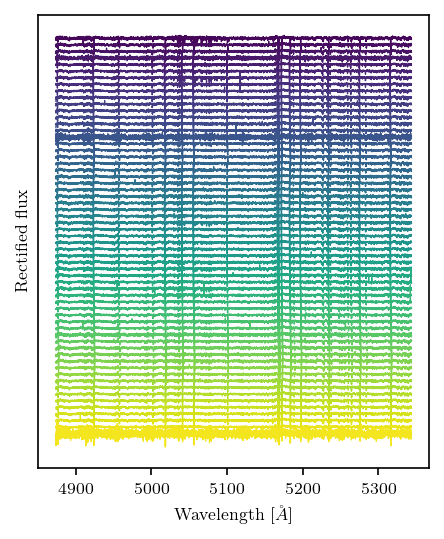

In [72]:
import seaborn as sns
plt.figure(figsize=[3.3648124999999998, 4.])
epochs = len(sorted(glob.glob('thuban/data/song-395/*.fits')))
colors = np.array(sns.color_palette('viridis', n_colors=epochs))

all_wavs, all_fluxes, all_ivars = [], [], []

for order in [15,16,17,18,19,20,21,22,23,24,25]:
    wavs, fluxes, ivars = [], [], []
    for epoch, color in zip(range(epochs), colors):
        wav, flux = get_spectra(epoch,order)
#         interp_wav, interp_flux = interpolate_spectrum(wav, flux)
        smooth_flux = smooth_spectrum(wav, flux, factor=0.03)
        flat_flux = flatten_spectrum(wav, smooth_flux, s=10)
        
        wavs.append(wav)
        fluxes.append(flat_flux)
        ivars.append(np.ones_like(flat_flux))
        
        plt.plot(wav, flat_flux - epoch * 0.1, linewidth=0.6, c=color, alpha=1.);
    all_wavs.append(wavs)
    all_fluxes.append(fluxes)
    all_ivars.append(ivars)
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Rectified flux')
plt.yticks([])

In [73]:
data = wobble.Data()
data.N = epochs
data.R = len([15,16,17,18,19,20,21,22,23,24,25])
data.orders = np.array(list(range(data.R)))
data.ivars = np.array(all_ivars)

In [74]:
data.R

11

In [75]:
data.xs = np.array(all_wavs)
data.ys = np.array(all_fluxes)

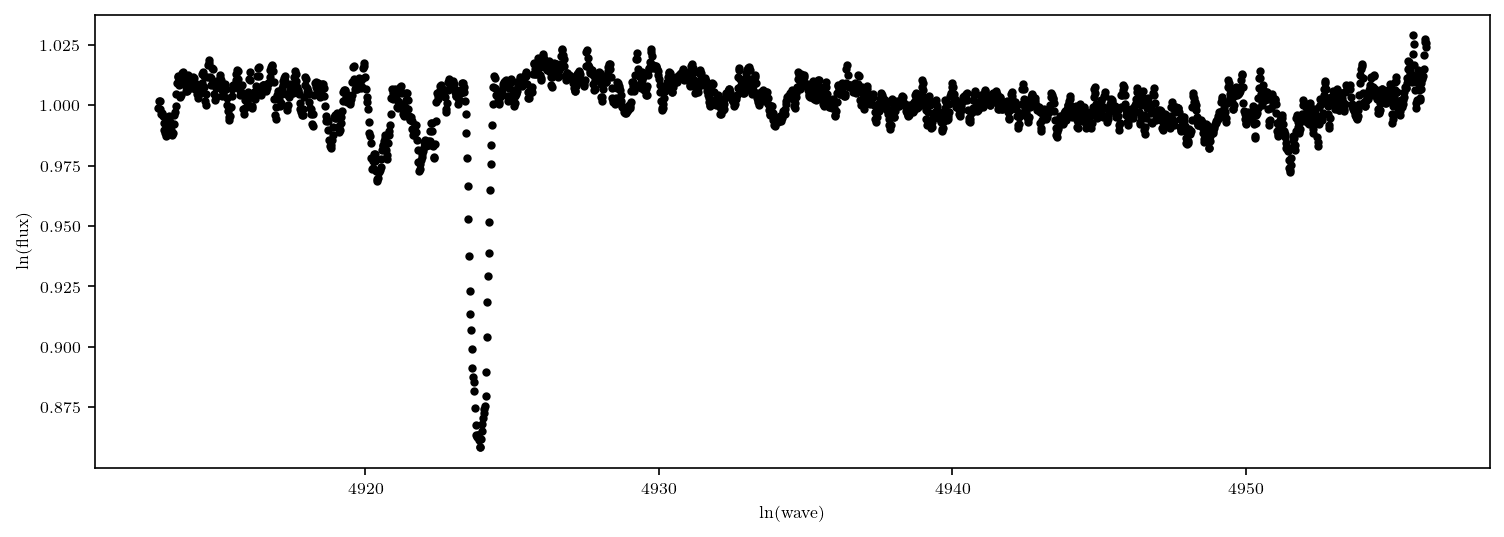

In [76]:
r = 1 # index of echelle order to plot
n = 40 # index of epoch to plot
plt.plot(data.xs[r][n], data.ys[r][n], 'k.', ms=6)
plt.ylabel('ln(flux)')
plt.xlabel('ln(wave)');

In [77]:
data.orders

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [78]:
results = wobble.Results(data=data)

r = 10 # index into data.orders for the desired order
model = wobble.Model(data, results, r)
model.add_star('star')
model.add_telluric('tellurics')

/Users/danielhey/anaconda3/envs/wobble/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danielhey/anaconda3/envs/wobble/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [79]:

wobble.optimize_order(model)

ValueError: operands could not be broadcast together with shapes (61,2048) (0,1) 

In [71]:
data.ivars

[]